# The Seats-Votes Curve in a Single Election

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

In the last notebook, we talked about the concept underlying *historical* seats-votes relationships. At its core, though, estimating seats-votes relationships in this manner is

1. **wasteful**: in each election, we observe a ton of district-level information. However, we disregard nearly all of this information about district-level *vote* results in favor of exclusive examination of the *district* winners. While winning a district or not *is* information about district-level vote (it's a censored variable with a threshold of $.5$), this is not the same as the original information in the vote shares. 
2. **dubious**: over many elections, the seats-votes model does *not* account for structural changes to the electorate, the party system, or the electoral process. This means that each election is considered comparable to every other election, even when they're separated by *large* expanses of time or structural changes to the electoral system.

These kinds of objections are noted by Browning & King (1987) but are most forcefully discussed by Gelman & King (1994). Incorporating older arguments (e.g. Mackerras (1962), among others), this line of argument seeks to define seats votes curves *in a single election* using a basic counterfactual argument: when shifts in party popular vote occur, these votes tend to be distributed uniformly at random among districts. 

In this notebook, we'll talk about how this kind of seats-votes curve is built within a single election, how the *uniform partisan swing* assumption works, and how it might not quite capture the true reality of how votes change from election to election. But, first, though, we'll have to read the data again. 

In [1]:
import pandas
import pysal
import numpy
import seaborn
import seatsvotes
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
house = seatsvotes.data.congress(geo=True)
house.crs = {"init":"epsg:4269"}
house = house.to_crs(epsg=5070)

In [3]:
house.head()

,index,congress,year,delsouth,state_fips,contest_ui,inc,king_dist,lewis_dist,state_name,turnout,vote_share,geom_uid,geometry
0,870,107,2000,0,06,107006026,1,NaN,26,california,96500.0,1.000000,006103107026,POLYGON ((-2035775.761381865 1494606.630854639...
1,871,107,2000,0,06,107006029,1,NaN,29,california,226079.0,0.797487,006103107029,"POLYGON ((-2026676.55813503 1472460.195548936,..."
2,872,107,2000,0,06,107006030,1,NaN,30,california,95011.0,0.875930,006103107030,"POLYGON ((-2011853.30096701 1467542.286440545,..."
3,873,107,2000,1,12,107012013,-1,NaN,13,florida,275486.0,0.361427,012105107013,"(POLYGON ((1339081.34287222 619572.4289258342,..."
4,874,107,2000,1,12,107012014,-1,NaN,14,florida,242614.0,0.000000,012105107014,"(POLYGON ((1388687.535007545 543393.538895309,..."


# Seats & Votes in a single election

At its core, analyzing a seats-votes relationship in a single election is somewhat suspect. This is because the relationship between votes and seats is a *strict hinge-point* relationship in most two-party elections. Once the reference party gets beyond 50% in the two-party vote (i.e. once Dems get more votes than Republicans), the district is "won," and represented by a $1$. In the other direction, the district is lost. This makes for a pretty boring scatterplot:

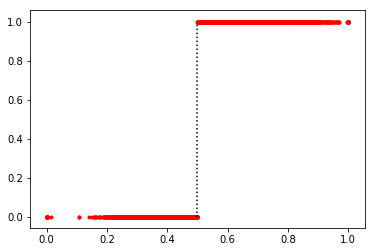

In [4]:
plt.scatter(house.vote_share, house.vote_share > .5, marker='.', color='r')
plt.vlines(.5, 0,1, linestyle=':', color='k', )

Indeed, there's no real mechanism to be learned here; the basic relationship is simply one of a censored variable; when Dems win a majority of the two-party vote, they win the seat; when Dems win a minority, Republicans win. 

### Uniform Partisan Swing

So, how do we model the seats-votes curve in a single election? We can't do it *directly* based on the split of districts that are won (or lost). Instead, a classic method to construct the seats-votes curve relies on the assumption of *uniform partisan swing*, that changes in a party's popular vote are reasonably modelled by assigning those changes to *districts* uniformly. So, if Dems change in their popular vote by 10%, then we simply subtract 10% of each districts' vote shares. 

Unfortunately, this returns us to the same issue noted before about the difference between *average district voteshare* and *party popular vote*. This distinction leads to some rather finnicky issues with assuming uniform partisan swing. For example, a change of 10% in a district with *many* voters will result in a larger bump to the popular vote than a 10% change to a small district. Thus, it becomes more common to examine a party's average voteshare across districts, rather than the party's popular vote. Further, it again becomes common to assume that, when vote shares are expected to go below $0$ or above $100%$, the vote shares stop changing for that district. Complexities remain about *uncontested* districts, and we'll treat those later. 

Thinking about a *seats-votes* curve estimated using uniform partisan swing, we can build one in a pretty direct fashion. We'll focus first on building the seats-votes curve under uniform swing around a point we *did observe:* a single election. Let's pick out an election in particular, the 2006 election:

In [5]:
house06 = house.query('year == 2006')

Since this is only a single election, we only get one single observation of the average Democrat vote share, and one observation of how many districts the Dems won in that election. Below, we'll plot this as a single point, marked as a red `x`:

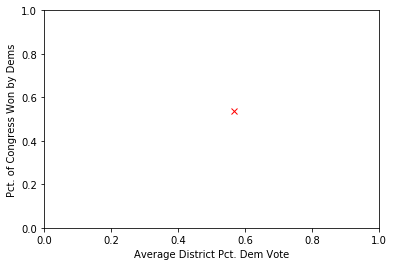

In [6]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot(house06.vote_share.mean(), (house06.vote_share > .5).mean(), marker='x', color='r')
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

Now, uniform partisan swing basically works by asking:

> if a party were to win $\delta$% more in each district, how many districts that party win? 

By asking that question for a few different values of $\delta$, we can build up a sequence of hypothetical district average vote shares which show the underlying seat-vote relationship latent in our data, *assuming (of course)* that the uniform swing hypothesis holds as a reasonable model of how votes in districts change as the average district vote changes.

So, let's see what happens when Democrats win 1% more in each district. Below, we'll add `.01` to each observation, and record the number of seats Dems would have won if each district increases in Democrat vote share by exactly one percentage point:

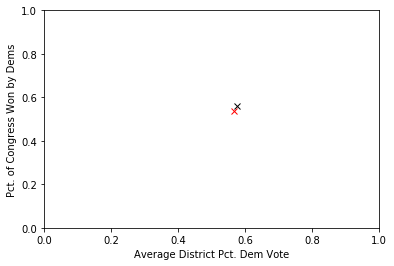

In [7]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.plot((house06.vote_share + .01).mean(), 
        ((house06.vote_share + .01) > .5).mean(), marker='x', color='k')
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

Wow! there's a very small increase in the share of seats Dems win when every district's voteshare increases by 1%. This suggests that one or more districts $i$ have a vote share $v_i$ such that $v_i < .5$ but $v_i + .01 > .5$. Thus, when all districts increase in their Democrat vote share by a single percentage point, the districts flip from being won by Republicans to being won by Democrats. 

Given that we can do this with an increase towards *Democrats*, we can also *decrease* all Democrat vote shares by a single percentage point and model a uniform partisan swing towards Republicans:

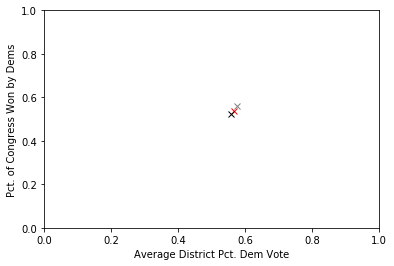

In [8]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.plot((house06.vote_share + .01).mean(), 
        ((house06.vote_share + .01) > .5).mean(), marker='x', color='grey')
ax.plot((house06.vote_share - .01).mean(), 
        ((house06.vote_share - .01) > .5).mean(), marker='x', color='k')
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

More districts flip! This suggests that some district is won by Democrats with a margin smaller than 1%. 

Again, contingent on the uniform partisan swing assumption being realistic, we can do this over and over again for different values of $\delta$ and obtain the "seats-votes curve" for that election:

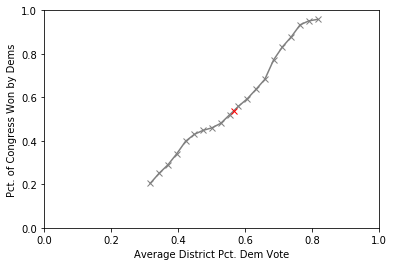

In [9]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot((house06.vote_share.mean() + numpy.linspace(-.25, .25, num=20)), 
        [((house06.vote_share + delta) > .5).mean() for delta 
         in numpy.linspace(-.25,.25,num=20)], marker='x', color='grey')
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

The curve above is the "empirical" seats votes curve, like that implemented by Simon Jackman in the `pscl` library in R. This "empirical" seats votes curve requires the uniform partisan swing assumption to construct; each point on the curve is given by some swing $\delta$ away from the observed average party vote share $\bar{v}$ and the fraction of districts at swing $\delta$ that are won by Democrats $(v_i + \delta > .5)$. Letting $\mathcal{I}$ stand for the indicator function which is 1 when the statement inside of it is true and zero otherwise, this means every point on the empirical seats-votes curve is a coordinate:

$$ \left(\bar{v}, \sum_i^N \mathcal{I}\left( (v_i + \delta) > .5\right)n^{-1}\right)$$

And the functional form of the "empirical" seats-votes curve is:

$$f(\delta) = \sum_i^N \mathcal{I}\left((v_i + \delta) > .5\right)n^{-1} $$

Looking at this definition, a few things become apparent. First, this method practically ignores districts that go way above $1$ or below $0$; while these are impossible (no district can have more Republican votes than there are voters in general), the seats-votes curve only considers districts relative to the threshold of victory, $.5$. This means that some vote shares from $v_i + \delta$ may actually be invalid vote shares. Second, while many doubt whether or not this model is a *realistic* model of how the electorate behaves, it's still suggested as a good first approximation for how the electoral system actually works, especially in the small region around the observed voteshare (e.g. Jackman 2014). There is absolutely *no* uncertainty in this model of the seats-votes curve, however. Further, assuming that the average swing affects all districts equally can be patently unrealistic when thinking about elections as social or geographical processes. Finally, we can see that the empirical seats-votes curve is actually *much* bumpier than the plot above suggests: there is a finite number ($N$) of observed $v_i$, but $\delta$ changes continuously. This means that the $f(\delta)$ function changes in a stepwise fashion: as $\delta$ increases, some $v_i + \delta$ switches from being below $.5$ to being above $.5$; when this happens, the function increases by a single step $1/n$. In general, if districts are allowed to have *idential* $v_i$, the changes may only occur in multiples of $1/n$, but these remain *integral* changes. 

Indeed, this step change property belies a much more important fact: this "model" of the seats-votes curve built from this restrictive "uniform partisan swing" assumption is actually a much more basic expression of the empirical structure of the data. Nagle (2018) provides a very good discussion of this; the seats-votes curve (when constructed this way) contains the same information as the empirical cumulative distribution function for $v_i$. 

This means that no theory of partisan swing is necessary to construct this curve at all. We'll discuss this now. 

# Seats-Votes Curves as an Empirical CDF

Going back to our first observed point from the 2006 election, we'll zoom in really tight on the observed result. 

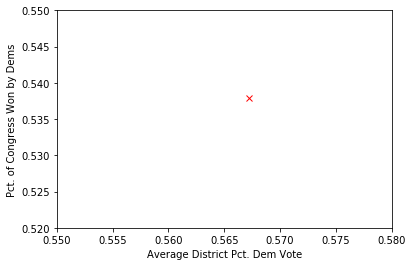

In [10]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot(house06.vote_share.mean(), (house06.vote_share > .5).mean(), marker='x', color='r')
ax.axis((.55,.58, .52,.55))
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

Now, we've discussed that *really small* changes in $\delta$ should reveal the integrality property. So, instead of changing $\delta$ by $.01$, we'll change $\delta$ **really finely** (like, $.00004$) near our observed value. This reveals the stepwise structure:

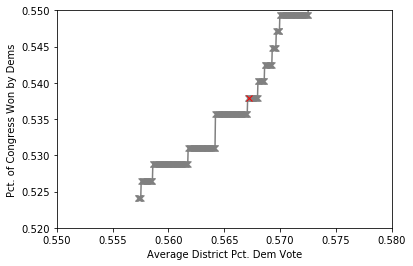

In [11]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot((house06.vote_share.mean() + numpy.linspace(-.01, .01, num=500)), 
        [((house06.vote_share + delta) > .5).mean() 
         for delta in numpy.linspace(-.01,.01,num=500)], 
        marker='x', color='grey')
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.axis((.55,.58, .52,.55))
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

Now we can see the stepwise structure. Again, this happens because seats are either *won* or they're *lost* by a party; no fractional seats are possible, so the seats-votes curve always assigns a discrete number of "wins" to Democrats. If there are 435 seats, the "estimated" seats-votes curve can only change $1/435$ at any step. Sometimes, the seats-votes curve can change more than $1/435$ at a time, like if two districts tie exactly in their vote shares. But, it can never change less than $1/435$ due to integrality. If we visualize this as light small lines in the plot we can see this effect very clearly:

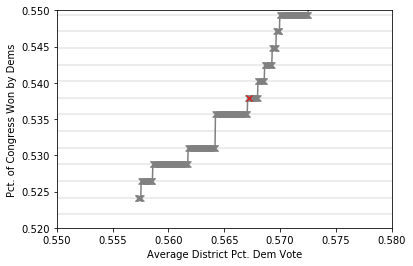

In [12]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
ax.plot((house06.vote_share.mean() + numpy.linspace(-.01, .01, num=500)), 
        [((house06.vote_share + delta) > .5).mean() for delta in numpy.linspace(-.01,.01,num=500)], marker='x', color='grey')
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.hlines((numpy.arange(1,435)/435), 0,1, color='k', linewidth=.15)
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
ax.axis((.55,.58, .52,.55))
plt.show()

Each of the horizontal lines is a change in exactly one seat. Note that two seats tie for the voteshares right around $.565$; we can see this by noting that the two district vote share percentages are so close to one another, they fall through the grid of values together. But, unless something ties *exactly*, the seats-votes curve only ever changes by a single seat at each percent vote value, and if the grid of $\delta$ became even finer, the curve would only increase exactly $1/435$ at a time.

To complete the last bit of relationship between the seats-votes curve and a cumulative density function, we need to obtain an expression that relates the two kinds of curves. 

So, can see that when a party popular vote share is exactly $\bar{v}$, then the seats-votes curve will be the count where $v_i>.5$. If we're *instead* at some swung vote share $\bar{v} + \delta$, the height of the seats-votes curve will be the percent of seats won at that *swung* vote share ($v_i + \delta > .5$). Moving to the *empirical cumulative density function* (ECDF), the height of the ECDF at an arbitrary value $x$ is the percent of all observations less than or equal to that value ($v_i < x$). Arbitrarily, let $x = \bar{v} - \delta$, we can see that the criteria for the ECDF is *identical to* the within-election seats-votes curve, shifted by a factor, $.5 - \bar{v}$:

$$ 
\begin{align}
v_i &< x \\
v_i &< \bar{v} - \delta \\
v_i &< \bar{v} - \delta + (.5 - .5) \\
v_i + \delta + .5- \bar{v} &< .5 \\
v_i + \delta + (.5- \bar{v}) &< .5 
\end{align}
$$

This holds for any $x$ in the domain of the cumulative density function, since $\delta$ is a free parameter and $\bar{v}$ is observed. 

The $.5 - \bar{v}$ factor isn't totally arbitrary: it's the *aggregate margin*, or the difference between the between the party's average voteshare in districts and $.5$, which is the threshold the party would need to control the legislature. Second, note that we've defined $x = \bar{v} - \delta$. This "flips" the direction of the seats-votes curve, since swings of size $\delta$ in the seats-votes curve are swings of size $-\delta$ in the ECDF. For a more rigorous discussion, again see my dissertation (Wolf, 2017) or Nagle (2018).
In practice, this means that the ECDF *for Republicans* and the seats-votes curve *for Democrats* are simply shifted & scaled versions of the same curve. Since we can construct the ECDF without reference to a theory of partisan swing, this suggests the "empirical" seats-votes curve is sufficiently more general than it might appear at first glance.

As far as our ability to compute seats-votes curves is concerned, this means we can use all of the standard methods for computing histograms to "estimate" empirical seats-votes curves under the uniform partisan swing assumption. Below, I'll show the empirical CDF and swing-built seats-votes curve from above, zoomed in:

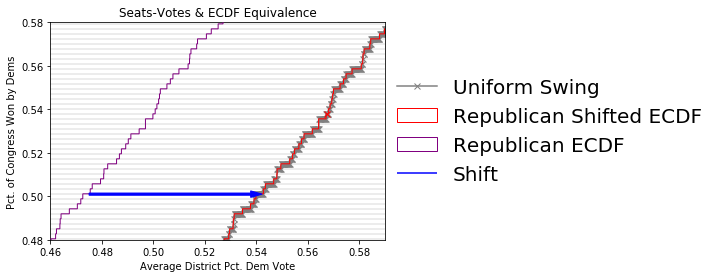

In [13]:
f = plt.figure()
ax = plt.gca()
ax.axis((0,1,0,1))
shift = .5 - house06.vote_share.mean()
ax.plot((house06.vote_share.mean() + numpy.linspace(-.10, .10, num=1000)), 
        [((house06.vote_share + delta) > .5).mean() 
         for delta in numpy.linspace(-.10,.10,num=1000)], 
        marker='x', color='grey', label='Uniform Swing')
ax.plot(house06.vote_share.mean(), 
        (house06.vote_share > .5).mean(), marker='x', color='r')
ax.hist(1-house06.vote_share - shift, cumulative=True, histtype='step', 
        density=True, bins=9000, color='red', zorder=100, 
        label='Republican Shifted ECDF')
ax.hist(1-house06.vote_share, cumulative=True, histtype='step', 
        density=True, bins=9000, color='purple', zorder=100, 
        label='Republican ECDF')
ax.hlines((numpy.arange(1,436)/435), 0,1, color='k', linewidth=.15)
ax.arrow(.475,.501,-shift, 0, color='b', 
          length_includes_head=True, zorder=100, label='Shift')
ax.hlines(1000,10001,1000, color='b', label='Shift') # because the shift label is disappearing
ax.legend(loc='center right', bbox_to_anchor=(2,.5), fontsize=20, frameon=False)
ax.axis((.46, .59, .48,.58))
ax.set_title("Seats-Votes & ECDF Equivalence")
ax.set_xlabel("Average District Pct. Dem Vote")
ax.set_ylabel("Pct. of Congress Won by Dems")
plt.show()

We can do this for the nation for each year to get a collection of seats-votes curves that apply to each year, or use *all* seats across the elections to build one collected seats-votes curve. In practice, when we have multiple seats-votes curves, it's usually best to visualize each separately, and consider the *consensus* curve to to be the median among the many different replications. We'll see this strategy in Gelman & King (1994), as well as McGann et al. (2015) and Wolf (2018). 

Below, though, I'll plot seats-votes curves using the shifted Republican ECDF for each election since 1994. 

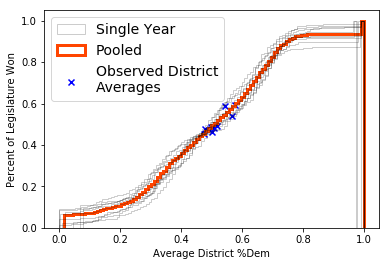

In [14]:
for year,chunk in house.groupby('year'):
    shift = .5 - chunk.vote_share.mean()
    plt.hist(numpy.clip(1-chunk.vote_share.dropna().values - shift, 0,1), 
             cumulative=True, density=True, histtype='step',
             color='k', bins=100, alpha=.2, zorder=1000, 
             label='Single Year' if year==2006 else None)
plt.scatter(house.groupby('year').vote_share.mean(), 
            house.groupby('year').vote_share.apply(lambda x: (x > .5).mean()),
            label='Observed District\nAverages', marker='x', color='b')
plt.hist(numpy.clip((1-house.dropna(subset=['vote_share']).vote_share.values) 
                    - (.5 - house.vote_share.mean()), 0,1),
         cumulative=True, density=True, histtype='step',
         color='orangered', bins=100, linewidth=3, label='Pooled')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel("Average District %Dem")
plt.ylabel("Percent of Legislature Won")
plt.show()

# Is the seats-votes curve realistic? 

The question of whether or not a seats-votes curve is *realistic* is quite distinct from *whether or not we can estimate it*. Again, following Nagle (2018), we can clearly "estimate" seats-votes curves for any number of replications from a model of elections. We can do this quickly, easily, and in a pretty straight-forward fashion. I'll talk a lot later about how there may be many different ways of constructing *stochastic* estimates of seats-votes curves, those that take into account the various random and co-varying factors that are involved in electoral processes. But, at its core, the question of whether or not we can estimate seats-votes curves easily is solved using Nagle (2018)'s relization about empirical CDFs and seats-votes curves. 

Their *realism* depends, though, on their interpretation. Interpreting seats-votes curves as empirical CDFs is not problematic at all. However, interpreting them *as a model* of how congressional control might change as district average vote shares change... that is problematic. In general, this interpretation hinges on how realistic the assumption of uniform partisan swing is. 

While we may take the uniform partisan swing curves as a good first-approximation for how the electoral system will work, there is a common perception that extremes of the seats-votes curves, the points that are far away from an observed $(\bar{v},\bar{s})$ point, are not "realible" representations of reality. In my own dissertation research, I found that policymakers, public officials, and stakeholders in Washington and and Arizona did believe that the whole range of $\bar{v}$ to $1-\bar{v}$ were possible, but that it was probably more likely that the structure of partisanship in the state would not change radically or flip in the control of the congressional delegation. This suggests that, for practitioners I interviewed, seats-votes curves may indeed have a narrow band of validity around the observed election results, and this band may encompass values where a party both wins or loses. This doesn't mean that the *estimation* of the curve is unrealible, but it *does* mean the model becomes unrealistic at large swings.

However, another component of the assumption of uniform partisan swing that I examined in my dissertation considered whether the assumption of *uniformity* makes sense *geographically*. That is, do nearby districts tend to swing the same direction (or, more-so than they may otherwise if swing were uniformly random)? It may be the case that small but *highly correlated* swings will behave differently from small uncorrelated swings. If *this* is true, it suggests that assuming that *all districts accrue the same changes* might be unrealistic, and this unrealism may affect the validity of the seats-votes curve as a conceptual model. 

To examine this more in depth, we can see the votes over the 2002-2010 elections to Congress.

In [15]:
aughties = house.query('year > 2000 & year < 2012')

Now, admitting that there are a few inter-censal redistrictings during this period, I'll assume that the redistricting map remains *mainly* unchanged, and that it is reasonable to compute swing between two districts in subsequent elections so long as they have the same district number. 

In [16]:
aughties['district_id'] = aughties.state_fips.astype(str).str.rjust(2,'0') \
                        + aughties.lewis_dist.astype(str).str.rjust(2, '0')

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now, I'm going to pivot the dataframe so that each row is a congressional district and each column is a year in which a vote share is recorded. 

In [17]:
pivot_table = aughties.pivot(index='district_id', 
                               columns='year', 
                               values='vote_share')
pivot_table.head()

year,2002,2004,2006,2008,2010
district_id,,,,,
0101,0.384417,0.368377,0.318440,0.000000,0.000000
0102,0.300415,0.284929,0.304612,0.503119,0.489062
0103,0.489307,0.387705,0.392786,0.459005,0.405193
0104,0.000000,0.251688,0.297387,0.251417,0.000000
0105,0.747845,0.730523,1.000000,0.518012,0.420643


Then, we'll compute the `diff` along columns and drop the first (since it has nothing to diff against):

In [18]:
swings = pivot_table.diff(axis=1).drop(2002, axis=1)
swings.head()

year,2004,2006,2008,2010
district_id,,,,
0101,-0.016039,-0.049937,-0.318440,0.000000
0102,-0.015486,0.019683,0.198507,-0.014057
0103,-0.101602,0.005081,0.066219,-0.053811
0104,0.251688,0.045700,-0.045970,-0.251417
0105,-0.017322,0.269477,-0.481988,-0.097368


We can see the swing distributions in each year:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f206c698438>,
      dtype=object)

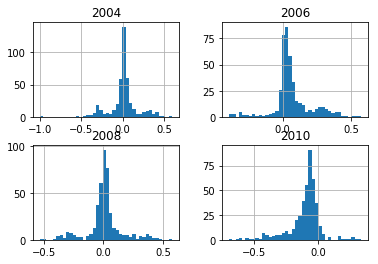

In [19]:
swings.hist(bins=40)

Now, swing is *quite* noisy when considering both contested and uncontested elections together. We see that, in general, there appear to be three modes in these distributions. These tend to be where elections change between contested and uncontested across two elections. If we focus in on the cases where elections are contested, we'll have a bit of a cleaner time when we move to the map. Thus, let's focus on the middle 80% first, and return later to the problem of uncontested elections. 

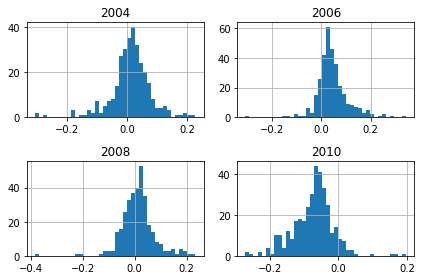

In [20]:
midswing = aughties.query('vote_share < .9 & vote_share > .1')\
                    .pivot(index='district_id', 
                           columns='year', 
                           values='vote_share')\
                    .diff(axis=1).drop(2002,axis=1)
midswing.hist(bins=40)
plt.tight_layout()
plt.show()

Given this drop of uncontested elections, contests where *either* year is uncontested result in null swing. But, looking generally at a map of the swings (here, we'll focus on 2004), we can see that it does indeed appear to cluster in space:

In [21]:
spswing = aughties.merge(midswing[2004].to_frame('swing'), 
                         left_on='district_id', 
                         right_index=True,how='left')
spswing = spswing.query('state_name not in ("alaska", "hawaii")')

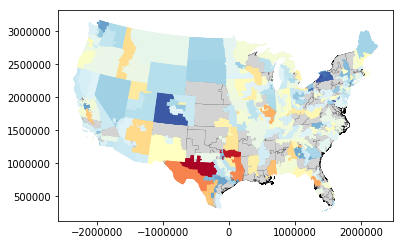

In [22]:
ax = spswing[~spswing.swing.isnull()].plot('swing', cmap='RdYlBu')
spswing[spswing.swing.isnull()].plot(color='lightgrey', edgecolor='k', 
                                     linewidth=.1, zorder=-1,ax=ax)

Given that we've focused only on contested elections in both cycles, it appears that the changes in vote share between years *does* tend to be spatially dependent. To verify this, we can start by using Moran's $I$, which is kind of like a spatial correlation coefficient. This will tell us how correlated a given congressional district's swing is with other nearby districts. Over all districts, this will tell us whether the *swing* at any site tends to be related to swing in nearby sites. If districts that are near each other tend to experience the same swing, then it is not really the case that swing exists uniformly at random across contested elections. Instead, there are *correlated swings*: areas that are near each other tend to swing together. 

In [23]:
Is = []
for y in numpy.arange(2004,2012,2):
    spswing = aughties.merge(midswing[y].to_frame('swing'), 
                         left_on='district_id', 
                         right_index=True,how='left')
    spswing = spswing.query('state_name not in ("alaska", "hawaii")')
    spswing = spswing.dropna(subset=['swing'])
    W = pysal.weights.Queen.from_dataframe(spswing)
    Is.append(pysal.Moran(spswing.swing.values, W))

We can visualize this in on of two ways. First, we can simply look at the estimate of Moran's $I$ and its standard error in each year:

Text(0.5,0,"Moran's I for queen congressional district swings")

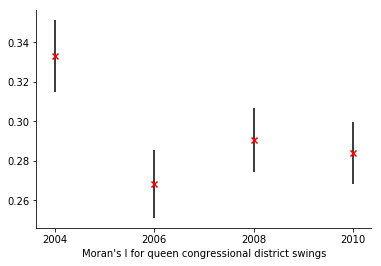

In [24]:
plt.errorbar(numpy.arange(2004,2012,2), 
             [mi.I for mi in Is],
             [2*(mi.VI_rand**.5) for mi in Is],
             fmt='none', color='k')
plt.scatter(numpy.arange(2004,2012,2), 
             [mi.I for mi in Is], marker='x', color='r', zorder=100)
plt.xticks(numpy.arange(2004,2012,2))
seaborn.despine()
plt.xlabel("Moran's I for queen congressional district swings")

Or, we can look at the scatterplot relating the swing in a contested election to the swing in neighboring districts in each year:

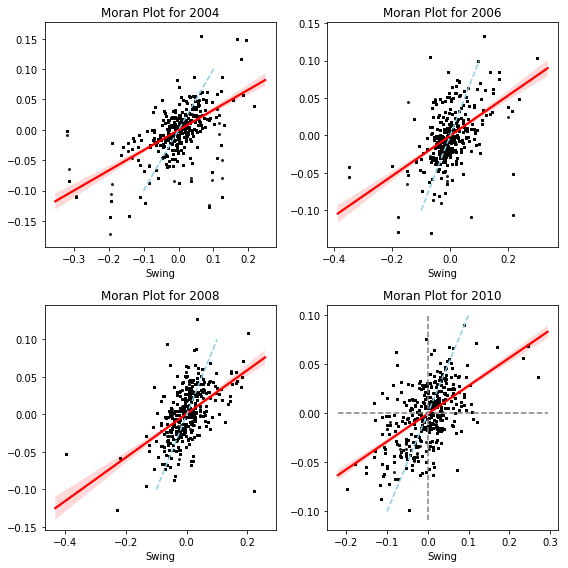

In [31]:
f,ax = plt.subplots(2,2,figsize=(8,8))
for i,year in enumerate(numpy.arange(2004,2012,2)):
    ax_ = ax.flatten()[i]
    seaborn.regplot(Is[i].z, 
                    pysal.weights.lag_spatial(Is[i].w, Is[i].z), 
                    ax=ax_, scatter_kws=dict(color='k', marker='.', s=4),
                    line_kws=dict(color='r'))
    ax_.hlines(0,*plt.xlim(), linestyle='--', color='grey')
    ax_.vlines(0,*plt.ylim(), linestyle='--', color='grey')
    ax_.plot((-.1,.1), (-.1,.1), color='skyblue', linestyle='--')
    ax_.set_title("Moran Plot for {}".format(year))
    ax_.set_xlabel("Swing")
f.tight_layout()
plt.show()

Thus, we see clearly that swing is *not* uniformly random over space; areas that are near each other tend to break towards (or away from) candidates in a simlar fashion.